# Regression Analysis on Bike Sharing Dataset 🚲📈

In this notebook, we will delve into regression analysis using the Bike Sharing dataset obtained from the UCI Machine Learning Repository. Our objective is to develop a predictive model that accurately forecasts the bike count based on various attributes, including weather conditions and other factors.

#### Problem Statement

The Bike Sharing dataset provides hourly information on bike counts along with weather and other attributes. Our goal is to build a regression model capable of predicting the bike count accurately.

#### Regression Modeling Approach

For this analysis, we will employ a Decision Tree based regression approach. The hourly bike count will be our target variable, while weather attributes, time-related features, and other relevant factors will serve as our predictors.

**Created by: José Rubén García García**

**March, 2024**


# Decision Tree based regression

## Loading resources

In [8]:
%matplotlib inline

# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# plotting libraries
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [9]:
hour_df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


## Preprocessing 


In [10]:
#Standardize column names

hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [11]:
#Typecast attributes
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# variables to categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

### Encode Categorical (One Hot Encoding)
Since we have some categorical features always is a good idea to apply a categorical encode, the method that I will use is the one called as One hot encoding or "OHE" 

In [12]:
def fit_transform_ohe(df, col_name):
    """This function performs one hot encoding for the specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the mentioned column name.
        col_name (str): The column to be one hot encoded.

    Returns:
        tuple: LabelEncoder, OneHotEncoder, transformed column as pandas DataFrame.

    """
    # Label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # One hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le, ohe, features_df

def transform_ohe(df, le, ohe, col_name):
    """This function performs one hot encoding for the specified column using the specified encoder objects.

    Args:
        df (pandas.DataFrame): The DataFrame containing the mentioned column name.
        le (LabelEncoder): The label encoder object used to fit label encoding.
        ohe (OneHotEncoder): The OneHotEncoder object used to fit one hot encoding.
        col_name (str): The column to be one hot encoded.

    Returns:
        pandas.DataFrame: Transformed column as pandas DataFrame.

    """
    # Label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # One hot encoding
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df


### Train and test splitting


In [13]:
#splitting the train and test in a 67% - 33% relationship properly 
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [15]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

### Encoding

In [17]:
#Looping through the list of categorical variables to transform and prepare a list of encoded attributes
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc': return_obj[1],
                              'feature_df': return_obj[2],
                              'col_name': col}) 

In [18]:

feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [19]:
train_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.64,0.65,0.1940,0,5,9,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.50,0.45,0.2239,13,2,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.86,0.47,0.5224,12,0,8,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.30,0.61,0.0000,2,3,2,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.54,0.19,0.4179,17,6,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Training

In [21]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

X.shape,y.shape

((11643, 19), (11643, 1))

In [24]:
#Create the Regression tree object
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)


dtr.fit(X,y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_split=5)

In [30]:
#Creating a representation of the decision tree created
dot_data = tree.export_graphviz(dtr, out_file=None, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("Decision_tree_bikeshare.pdf")


True

In [31]:
dtr.score(X,y)

0.5645919317952333

### Grid Search With Cross Validation

In [41]:
param_grid = {"criterion": ["squared_error"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)
grid_cv_dtr.fit(X,y)


GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['squared_error'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

### Cross Validation: Best Model Details

In [42]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.8333284746008405
Best Hyperparameters::
{'criterion': 'squared_error', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [43]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034596,0.025344,0.020835,0.016533,squared_error,2,5,20,10,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,91
1,0.019459,0.006652,0.016001,0.013998,squared_error,2,5,20,20,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,91
2,0.017017,0.011941,0.003825,0.001263,squared_error,2,5,20,40,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,91
3,0.012581,0.001405,0.002403,0.000048,squared_error,2,5,40,10,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,91
4,0.010343,0.000558,0.003531,0.000959,squared_error,2,5,40,20,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,91


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

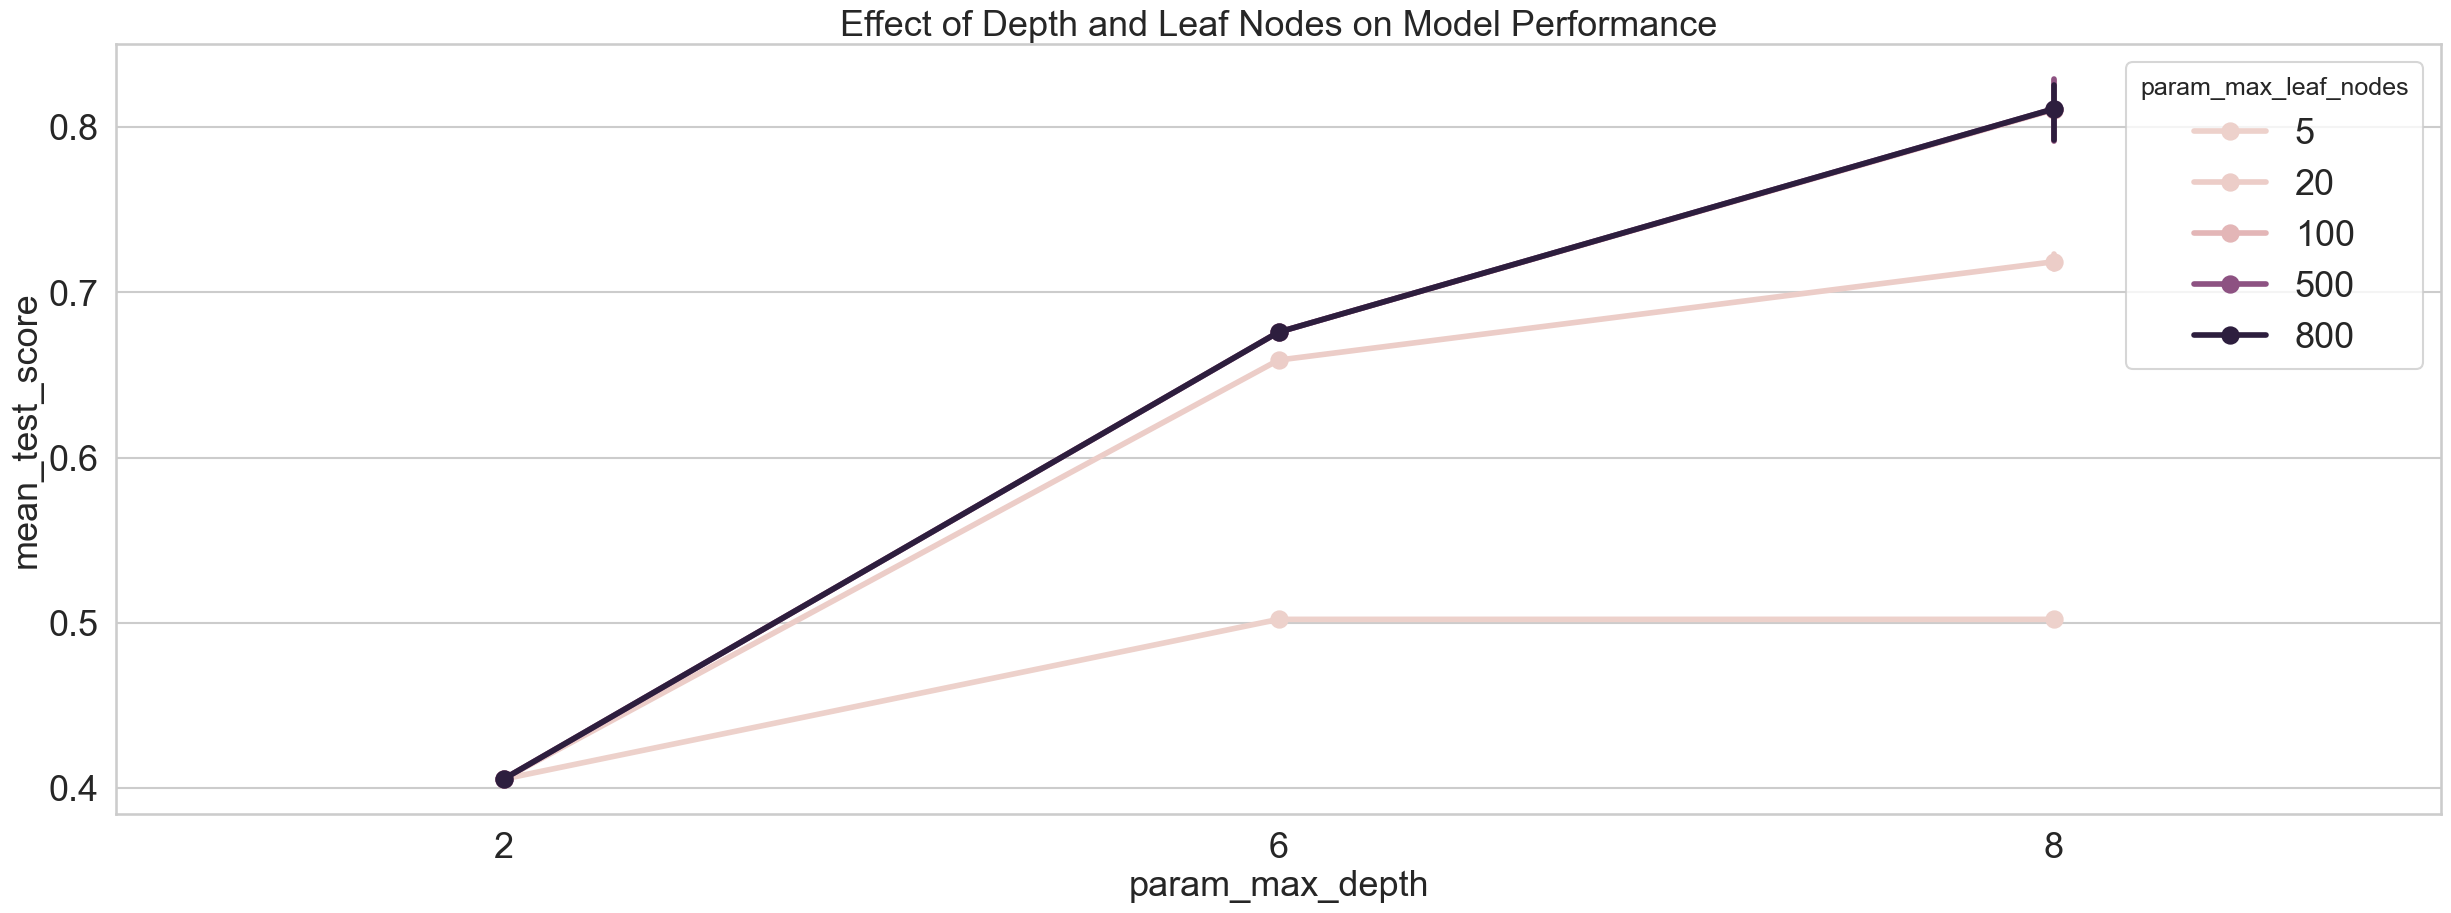

In [45]:
#PLotting impact of depth of the tree on the overall score along with the number of lead nodes.
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

### Residual Plot


In [46]:

predicted = grid_cv_dtr.best_estimator_.predict(X)
residuals = y.flatten()-predicted

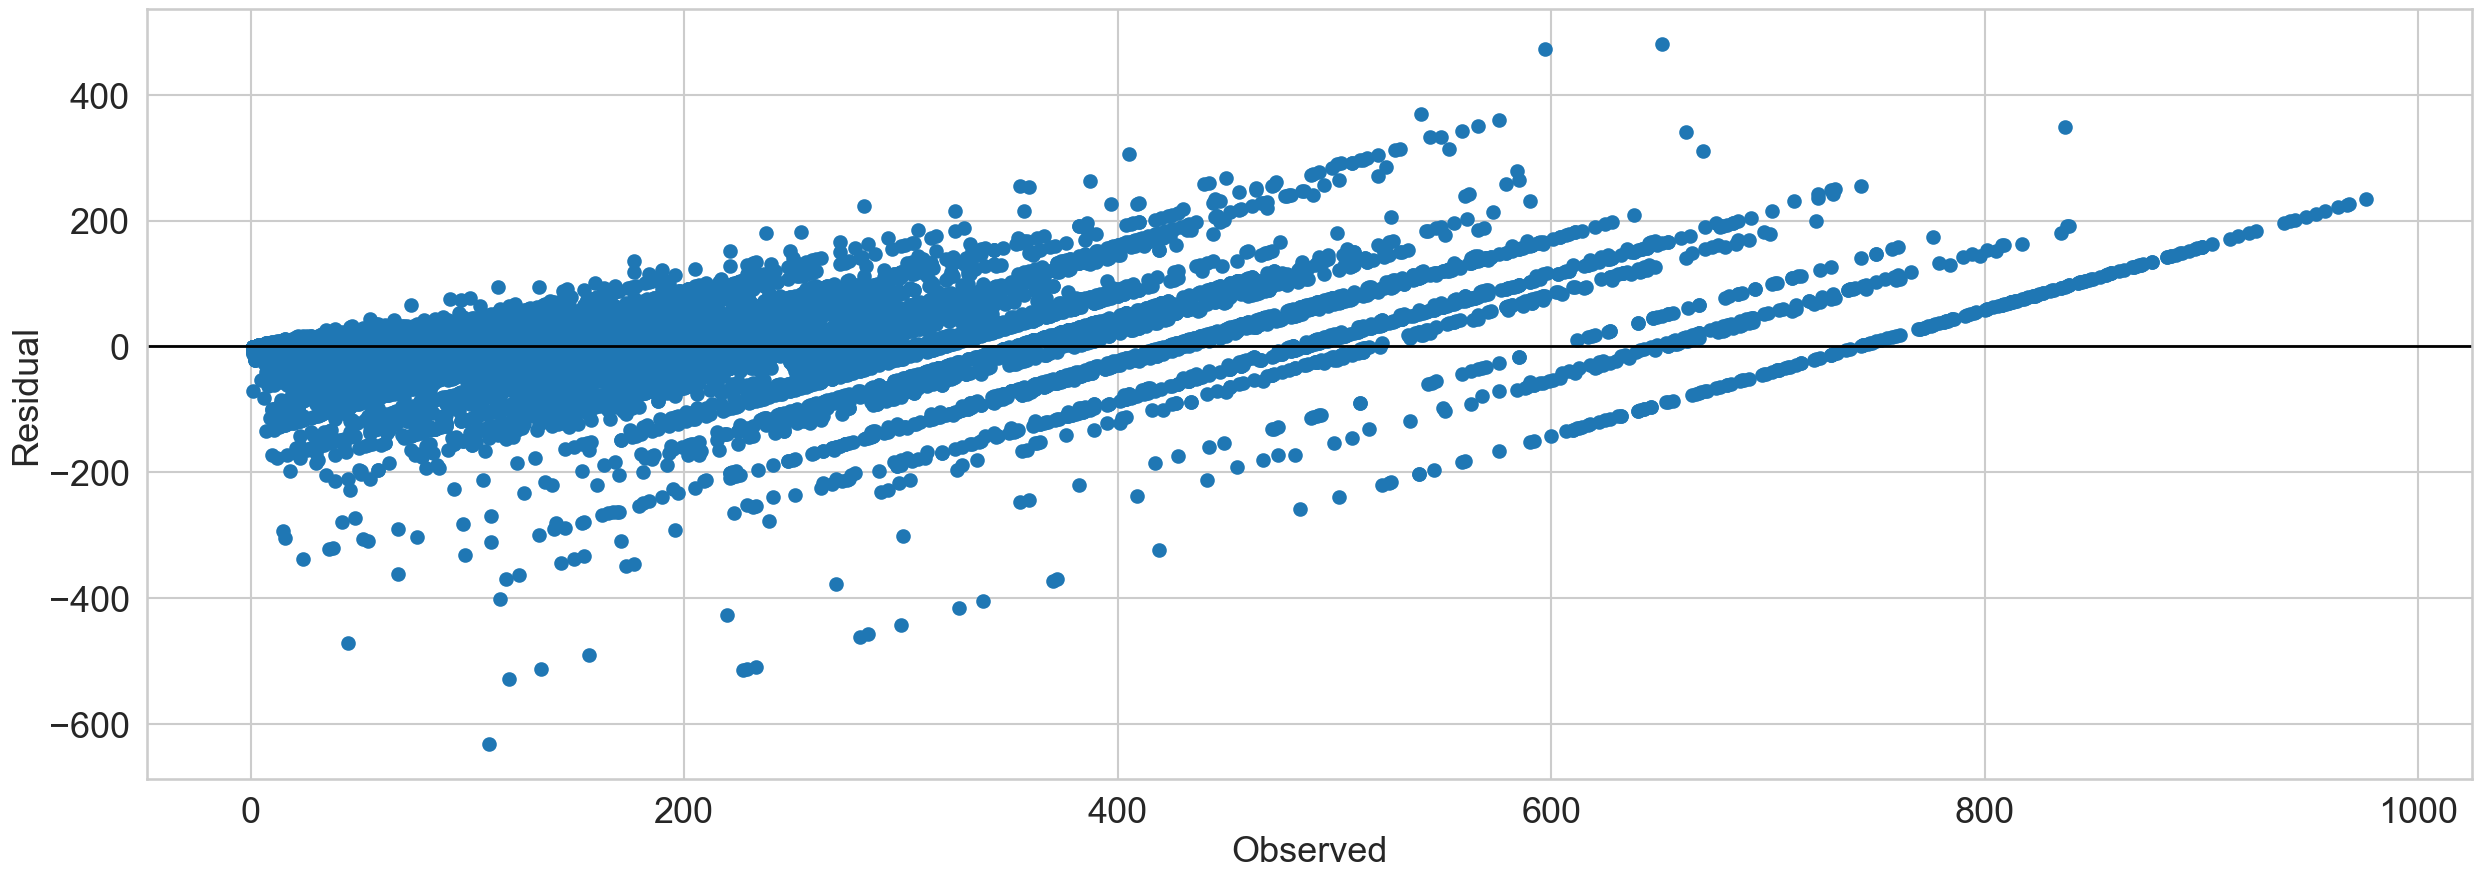

In [47]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [48]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

In [49]:
print("avg R-squared::{}".format(np.mean(r2_scores)))
print("MSE::{}".format(np.mean(mse_scores)))

avg R-squared::0.8375947941827327
MSE::-5406.524488092738


In [50]:
best_dtr_model = grid_cv_dtr.best_estimator_

### Testing Dataset Performance


In [51]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [52]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [53]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [54]:
r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.8478415542500741
MSE: 4854.08


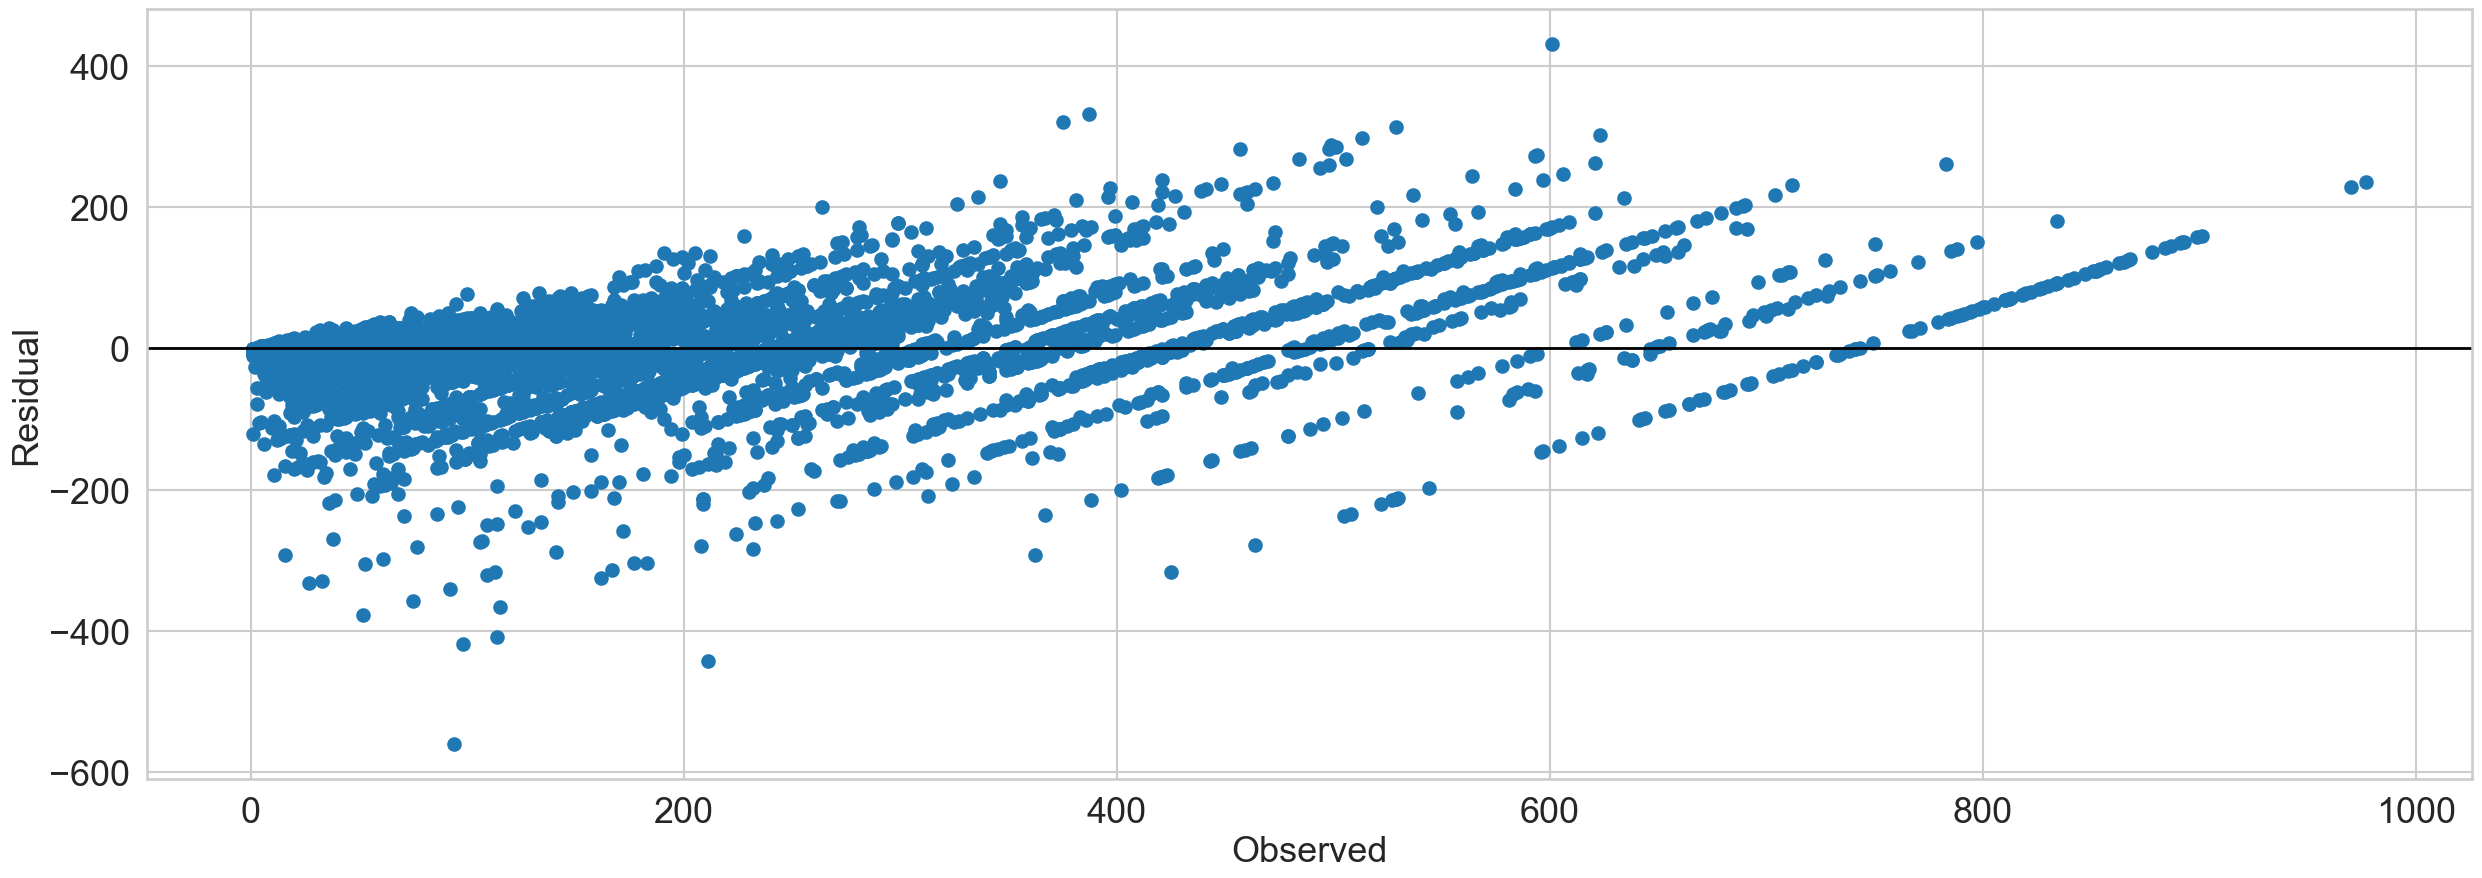

In [55]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)

## Interpretation of Decision Tree Regression Results

In the analysis using a decision tree-based regression model on the test data, we obtained the following performance metrics:

### R-squared (R2)
- R-squared measures the proportion of the variance in the target variable (bike count) that is explained by the independent variables (features) in the model.
- A higher R-squared value indicates a better fit of the model to the data, with values closer to 1 suggesting a stronger explanatory power.
- Our model achieved an R-squared value of approximately 0.85 (0.8478), indicating that around 85% of the variance in the bike count is explained by the features included in the model. This suggests a reasonably good fit of the model to the data.

### Mean Squared Error (MSE)
- MSE measures the average squared difference between the actual and predicted values of the target variable.
- A lower MSE indicates that the model's predictions are closer to the actual values on average.
- Our model yielded an MSE of approximately 4854.08, implying that, on average, the squared difference between the actual and predicted bike counts is around 4854.08. While lower MSE values are generally desirable, it's essential to consider the scale and context of the target variable.

Overall, based on these metrics, the decision tree-based regression model demonstrates reasonably good performance on the test data.
